In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ImageToStringPreprocessing:
    def __init__(self, image):
        self.original_image = image
        self.image_binary = self._preprocess(image, to_binary=True)
        self.image_gray = self._preprocess(image, to_binary=False)

        self.image_bboxed, self.info = self._segment_and_analyze()
        self.letters_28x28 = self._extract_letters()

    def get_info(self):
        return self.info
    
    def get_bboxed_image(self):
        return self.image_bboxed
    
    def show_bboxed_image(self):
        plt.imshow(self.image_bboxed)
        plt.axis('off')
        plt.show()
    
    def show_letters(self):
        letters_28x28 = [x['img'] for x in self.get_info()]

        _, axes = plt.subplots(4, 8, figsize=(16, 8))
        for i, ax in enumerate(axes.flat):
            if i < len(letters_28x28):
                ax.imshow(letters_28x28[i], cmap='gray')
                ax.set_title(f"{i}")
            ax.axis('off')
        plt.tight_layout()
        plt.axis('off')
        plt.show()

    def _preprocess(self, image, mean_thresh=127, to_binary=False):
        # Converti in scala di grigi
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Normalizza tra 0 e 255
        gray_norm = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

        # Calcola la media d’intensità
        mean_intensity = np.mean(gray_norm)

        # Inversione se sfondo chiaro
        if mean_intensity > mean_thresh:
            gray_norm = cv2.bitwise_not(gray_norm)

        if to_binary:
            _, binary = cv2.threshold(gray_norm, 155, 255, cv2.THRESH_BINARY)
            return binary

        return gray_norm

    __MERGE_THRESHOLD=0.3

    def _segment_and_analyze(self):
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(self.image_binary)

        draw_img = self.original_image.copy()
        
        bboxes = [stats[label][:4] for label in range(1, num_labels)]

        bboxes.sort(key=lambda box: box[0])

        merged = [False] * len(bboxes)
        new_bboxes = []

        for i in range(len(bboxes)):
            if merged[i]:
                continue
            x1, y1, w1, h1 = bboxes[i]
            merged_box = [x1, y1, x1 + w1, y1 + h1]

            for j in range(i + 1, len(bboxes)):
                if merged[j]:
                    continue
                x2, y2, w2, h2 = bboxes[j]
                x_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
                min_width = min(w1, w2)
                overlap_ratio = x_overlap / min_width if min_width > 0 else 0
                # print("x_overlap:", x_overlap)
                # print("min_width:", min_width)
                # print("overlap_ratio:", overlap_ratio)
                # print("overlap_ratio >= MERGE_THRESHOLD", overlap_ratio >= self.__MERGE_THRESHOLD)

                if overlap_ratio >= self.__MERGE_THRESHOLD:
                    merged_box[0] = min(merged_box[0], x2)
                    merged_box[1] = min(merged_box[1], y2)
                    merged_box[2] = max(merged_box[2], x2 + w2)
                    merged_box[3] = max(merged_box[3], y2 + h2)

                    x1, y1, w1, h1 = bboxes[i] = (
                        merged_box[0],
                        merged_box[1],
                        merged_box[2] - merged_box[0],
                        merged_box[3] - merged_box[1]
                    )
                    merged[j] = True

            final_box = (
                merged_box[0],
                merged_box[1],
                merged_box[2] - merged_box[0],
                merged_box[3] - merged_box[1]
            )
            new_bboxes.append(final_box)
            cv2.rectangle(draw_img, (final_box[0], final_box[1]), (final_box[0] + final_box[2], final_box[1] + final_box[3]), (0, 255, 0), 1)

        # Bounding box generale della parola
        x_min = min(x for x, y, w, h in new_bboxes)
        y_min = min(y for x, y, w, h in new_bboxes)
        x_max = max(x + w for x, y, w, h in new_bboxes)
        y_max = max(y + h for x, y, w, h in new_bboxes)
        word_bbox = (x_min, y_min, x_max - x_min, y_max - y_min)

        word_height = y_max - y_min

        # Disegna la bounding box della parola
        cv2.rectangle(draw_img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 1)

        # Calcola le distanze in percentuale top e bottom, orizzontale in pixel
        distanze_verticali_top_pct = []
        distanze_verticali_bottom_pct = []
        distanze_orizzontali = []
        letter_imgs = []

        for i, (x, y, w, h) in enumerate(new_bboxes):
            dist_top_pct = 100 * (y - y_min) / word_height if word_height > 0 else 0
            dist_bottom_pct = 100 * (y_max - (y + h)) / word_height if word_height > 0 else 0
            distanze_verticali_top_pct.append(dist_top_pct)
            distanze_verticali_bottom_pct.append(dist_bottom_pct)

            if i < len(new_bboxes) - 1:
                x2, _, _, _ = new_bboxes[i + 1]
                distanza_dx = x2 - (x + w)
                distanze_orizzontali.append(distanza_dx)
            else:
                distanze_orizzontali.append(None)

            # Resize ---        
            cropped = self.image_gray[y:y+h, x:x+w]  # immagine in scala di grigi

            # Resize proporzionale
            if w > h:
                scale = 28 / w
                new_w = 28
                new_h = int(h * scale)
            else:
                scale = 28 / h
                new_h = 28
                new_w = int(w * scale)

            resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

            # Canvas nero (1 canale)
            canvas = np.zeros((28, 28), dtype=np.uint8)

            # Centra la lettera
            x_offset = (28 - new_w) // 2
            y_offset = (28 - new_h) // 2
            canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized

            letter_imgs.append(canvas)

        labels = ['bboxes', 'img', 'dist_top', 'dist_bottom', 'dist_dx']
        info_values = zip(new_bboxes, letter_imgs, distanze_verticali_top_pct, distanze_verticali_bottom_pct, distanze_orizzontali)
        info = [
            dict(zip(labels, v)) for v in info_values
        ]

        return draw_img, info
    
    def _extract_letters(self):
        letter_imgs = []
        for letter in self.info:

            x, y, w, h = letter['bboxes']

            cropped = self.image_gray[y:y+h, x:x+w]  # immagine in scala di grigi

            # Resize proporzionale
            if w > h:
                scale = 28 / w
                new_w = 28
                new_h = int(h * scale)
            else:
                scale = 28 / h
                new_h = 28
                new_w = int(w * scale)

            resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

            # Canvas nero (1 canale)
            canvas = np.zeros((28, 28), dtype=np.uint8)

            # Centra la lettera
            x_offset = (28 - new_w) // 2
            y_offset = (28 - new_h) // 2
            canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized

            letter_imgs.append(canvas)
        return letter_imgs

In [3]:
image_path = 'giraffa100%.png'
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

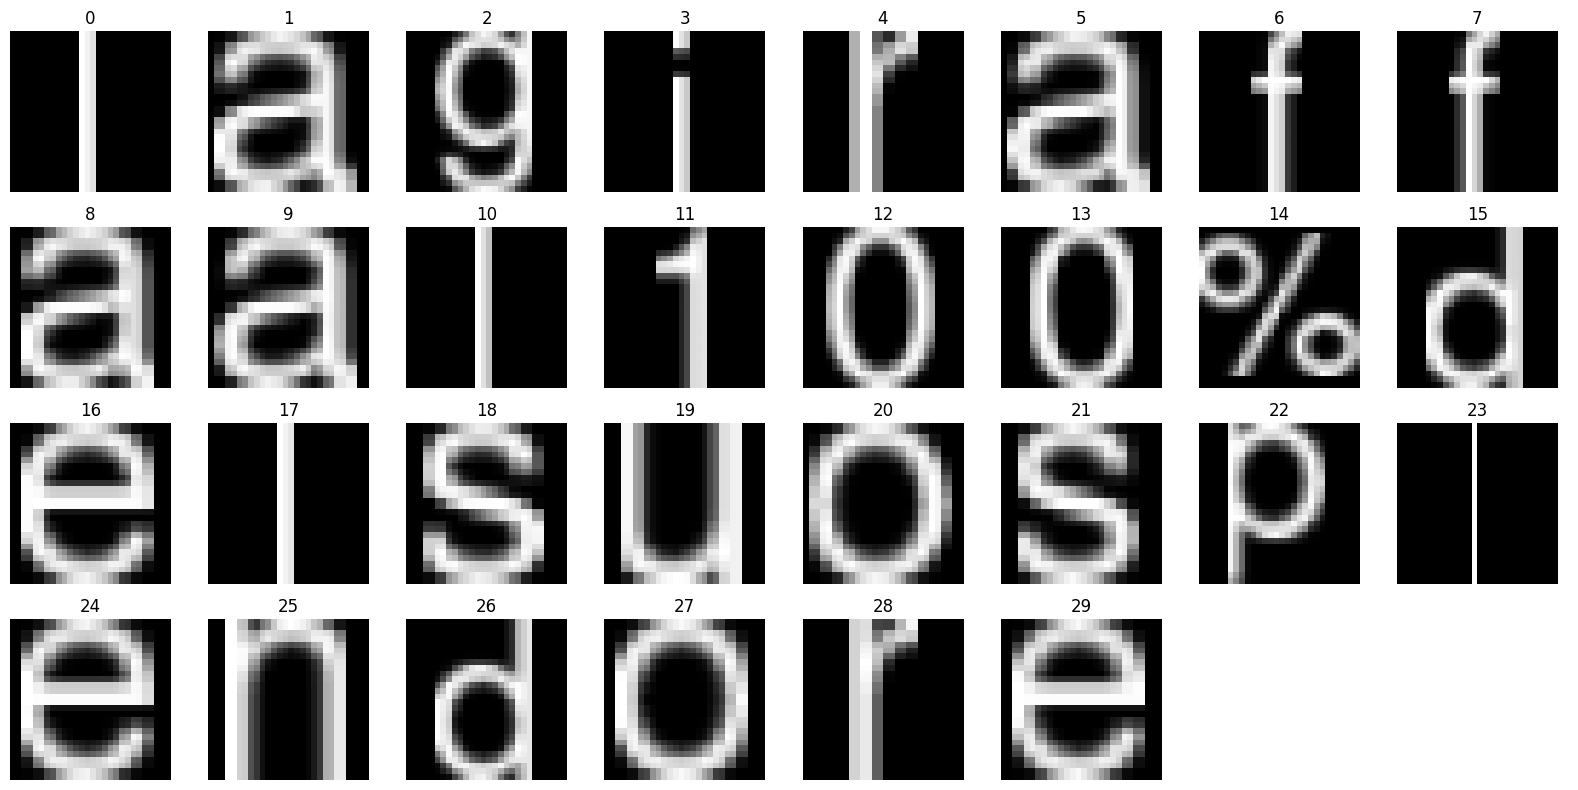

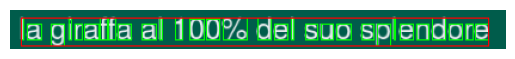

In [4]:
preprocessor = ImageToStringPreprocessing(image_rgb)

preprocessor.show_letters()
preprocessor.show_bboxed_image()

In [5]:
preprocessor.get_info()[0]

{'bboxes': (np.int32(9), np.int32(7), np.int32(2), np.int32(18)),
 'img': array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 226,
         213, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 226,
         213, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 226,
         213, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 226,
         213, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 226,
         213, 200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 226,
         213,